In [1]:
#ngày 14/7


In [1]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import imutils
import glob
import random
import csv
from PIL import Image, ImageOps

def rotate(image, angle, center = None, scale = 1):
    (h, w) = image.shape[:2]
    if center is None:
        center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def four_point_transform(image, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    warped = cv2.resize(warped, (1000, 600))
    return tl, tr, br, bl, warped

def order_points2(pts):
    rect = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def four_point_transform2(image, pts):

    rect = order_points2(pts)
    (tl, tr, br, bl) = rect
    return tl, tr, br, bl

def preprocess2(img):
    img = img.astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((5,5),np.uint8)
    erosion = cv2.dilate(gray,kernel,iterations = 1)
    gau = cv2.GaussianBlur(erosion, (5, 5), 0)
    edged = cv2.Canny(gau, 3, 200)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
    # loop over the contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.05 * peri, True)
        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            screenCnt = approx
#             print(type(screenCnt))
#             print(screenCnt)
            break
        else:
            screenCnt = np.array([[0,0], [0, 0], [0,0], [0, 0]])
            

    tl, tr, br, bl = four_point_transform2(img.copy(), screenCnt.reshape(4, 2))
    return tl, tr, br, bl, edged

def add_white_border(image, border_size):

    # Calculate the new dimensions
    height, width, _ = image.shape
    new_width = width + (2 * border_size)
    new_height = height + (2 * border_size)

    # Create a new white background image
    bordered_image = cv2.copyMakeBorder(image, border_size, border_size, 
                                                border_size, border_size, 
                                                cv2.BORDER_CONSTANT, value=(255, 255, 255))

    return bordered_image


In [2]:
path_bg = r"C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg2\bg2 (13).jpg"

path_img = r"C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\card\crop_ID_card_real\0c9hp2w5j3fqxki.jpg"



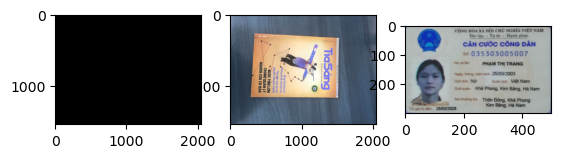

In [3]:
bg = cv2.imread(path_bg)
# bg = cv2.flip(bg, fl)
h, w, _ = bg.shape
black_bg = np.zeros((h, w, 3))

img = cv2.imread(path_img)
h_, w_, _ = img.shape


plt.subplot(1,3,1)
plt.imshow(black_bg)

plt.subplot(1,3,2)
plt.imshow(bg)

plt.subplot(1,3,3)
plt.imshow(img)

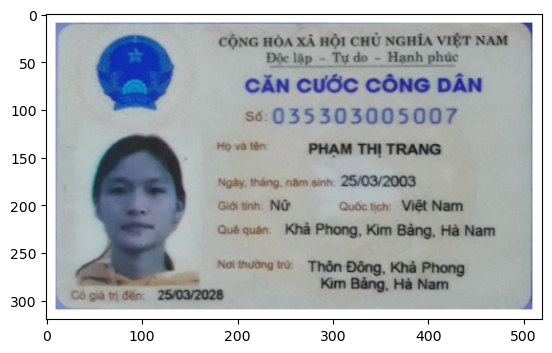

In [4]:
border_size = 10
img_border = add_white_border(img, border_size)
plt.imshow(img_border)

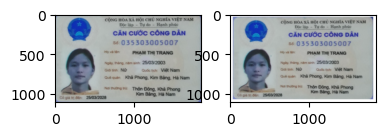

In [5]:
w_new = int(w*0.9)
h_new = int(h_*(w_new/w_))

out_auto = cv2.resize(img, (w_new, h_new) )
out_auto2 = cv2.resize(img_border, (w_new, h_new) )
h_, w_, _ = out_auto.shape

plt.subplot(1,3,1)
plt.imshow(out_auto)

plt.subplot(1,3,2)
plt.imshow(out_auto2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


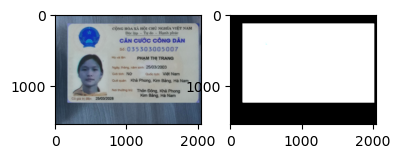

In [16]:
x_min = int(w*0.05)
y_min = int(h*0.05)
x_max = int(w*0.09)
y_max = int(h*0.09)

x1 = np.random.randint(x_min, x_max)
y1 = np.random.randint(y_min, y_max)


#add card in bg
if  (y1+h_) < h:
    bg[y1:y1+h_ , x1:x1+w_] = out_auto
    black_bg[y1:y1+h_ , x1:x1+w_] = out_auto2
    
# else:
#     continue
plt.subplot(1,3,1)
plt.imshow(bg)

plt.subplot(1,3,2)
plt.imshow(black_bg)

In [17]:
 tl, tr, br, bl, canny = preprocess2(black_bg)
    

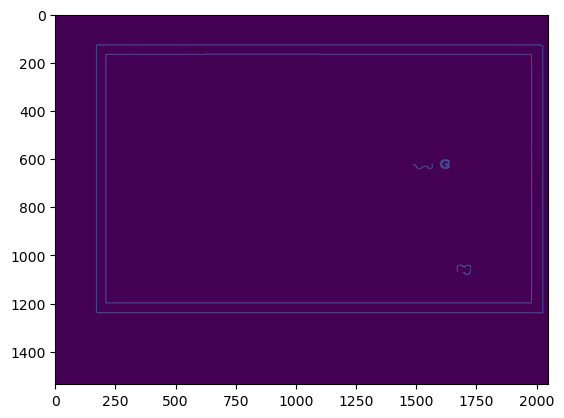

In [20]:
plt.imshow(canny)

In [18]:
print( tl, tr, br, bl)

[172. 129.] [2026.  132.] [2026. 1240.] [ 172. 1237.]


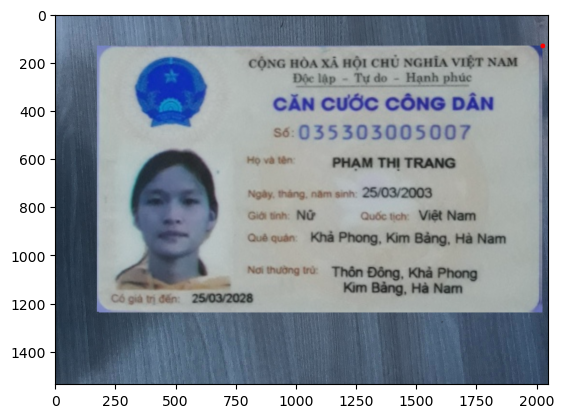

In [21]:
a = cv2.circle(bg.copy(), (2026,132), 10, 255, -1)
plt.imshow(a)

In [23]:
img = cv2.imread(r"C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\test_abc\images\train\0.jpg")

In [26]:
h, w, _ = img.shape

In [33]:
tl1 = int(0.06982421875*w)
tl2 = int(0.07486979166666667*h)

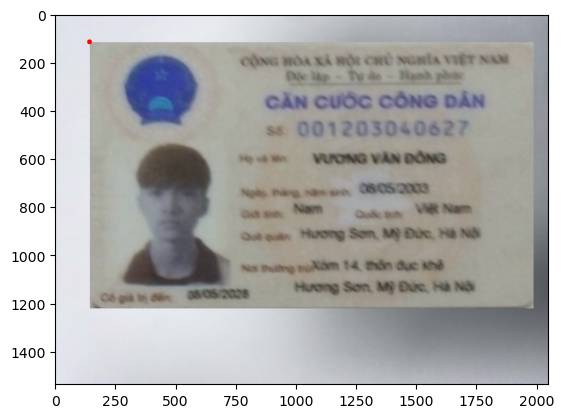

In [34]:
a = cv2.circle(img.copy(), (tl1,tl2), 10, 255, -1)
plt.imshow(a)
# plt.imshow(img)

In [ ]:
# 0 0.06982421875 0.07486979166666667 0.05 0.05
# 1 0.97119140625 0.07486979166666667 0.05 0.05
# 2 0.97119140625 0.7962239583333334 0.05 0.05
# 3 0.06982421875 0.7962239583333334 0.05 0.05